In [10]:
import torch
import torch.nn as nn
import torchvision
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import os
import numpy as np
import matplotlib.pyplot as plt
import time

In [2]:
class trainDataset(Dataset):
    def __init__(self):
        self.x_data = []
        self.y_data = []
        for filename in os.listdir('./final_train_data/same/train'):
            if 'input' in filename:
                temp = torch.load('./final_train_data/same/train/' + filename)
                temp = temp.cpu().numpy()
                self.x_data.append(temp)
                
                label_filename = filename.replace('input', 'label_same')
                temp = torch.load('./final_train_data/same/train/' + label_filename)
                temp = temp.cpu().numpy()
                self.y_data.append(temp)
            
    def __len__(self): 
        return len(self.x_data)


    def __getitem__(self, idx): 
        x = torch.FloatTensor(self.x_data[idx])
        y = torch.FloatTensor(self.y_data[idx])
        return x, y

In [3]:
class testDataset(Dataset):
    def __init__(self):
        self.x_data = []
        self.y_data = []
        for filename in os.listdir('./final_train_data/same/test'):
            if 'input' in filename:
                temp = torch.load('./final_train_data/same/test/' + filename)
                temp = temp.cpu().numpy()
                self.x_data.append(temp)
                
                label_filename = filename.replace('input', 'label_same')
                temp = torch.load('./final_train_data/same/test/' + label_filename)
                temp = temp.cpu().numpy()
                self.y_data.append(temp)
            
    def __len__(self): 
        return len(self.x_data)


    def __getitem__(self, idx): 
        x = torch.FloatTensor(self.x_data[idx])
        y = torch.FloatTensor(self.y_data[idx])
        return x, y

In [4]:
class UNET(nn.Module):
    def __init__(self, i_ch, o_ch):
        super().__init__()
        
        self.conv1 = self.contraction_block(i_ch, 32, 7, 3)
        self.conv2 = self.contraction_block(32, 64, 3, 1)
        self.conv3 = self.contraction_block(64, 128 ,3 ,1)
        
        self.upconv3 = self.expansive_block(128, 64, 3, 1)
        self.upconv2 = self.expansive_block(64*2, 32, 3, 1)
        self.upconv1 = self.expansive_block(32*2, o_ch, 3, 1)
        
    def __call__(self, x):
        conv1 = self.conv1(x)
        conv2 = self.conv2(conv1)
        conv3 = self.conv3(conv2)
        
        upconv3 = self.upconv3(conv3)
        upconv2 = self.upconv2(torch.cat([upconv3, conv2], 1))
        upconv1 = self.upconv1(torch.cat([upconv2, conv1], 1))
        
        return upconv1
    
    def expansive_block(self, i_ch, o_ch, filter_size, padding):
        block = nn.Sequential(torch.nn.Conv2d(i_ch, o_ch, kernel_size = filter_size, stride = 1, padding = padding ),
                             torch.nn.BatchNorm2d(o_ch),
                             torch.nn.ReLU(),
                             torch.nn.Conv2d(o_ch, o_ch, kernel_size = filter_size, stride = 1, padding = padding ),
                             torch.nn.BatchNorm2d(o_ch),
                             torch.nn.ReLU(),
                             torch.nn.ConvTranspose2d(o_ch, o_ch, kernel_size = 3, stride = 2, padding = 1, output_padding = 1))
        return block

    def contraction_block(self, i_ch, o_ch, filter_size, padding):
        block = nn.Sequential(torch.nn.Conv2d(i_ch, o_ch, kernel_size = filter_size, stride = 1, padding = padding ),
                             torch.nn.BatchNorm2d(o_ch),
                             torch.nn.ReLU(),
                             torch.nn.Conv2d(o_ch, o_ch, kernel_size = filter_size, stride = 1, padding = padding ),
                             torch.nn.BatchNorm2d(o_ch),
                             torch.nn.ReLU(),
                             torch.nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1))
        return block

In [5]:
def train(model, train_dl, valid_dl, loss_fn, optimizer, acc_fn, epochs=1):
    start = time.time()
    model.cuda()

    train_loss, valid_loss = [], []

    best_acc = 0.0

    for epoch in range(epochs):
        print('Epoch {}/{}'.format(epoch, epochs - 1))
        print('-' * 10)

        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train(True)
                dataloader = train_dl
            else:
                model.train(False)
                dataloader = valid_dl

            running_loss = 0.0
            running_acc = 0.0

            step = 0

            # iterate over data
            for x, y in dataloader:
                x = x.cuda()
                y = y.cuda()
                step += 1

                # forward pass
                if phase == 'train':
                    # zero the gradients
                    optimizer.zero_grad()
                    outputs = model(x)
                    y = y.squeeze(1)
                    loss = loss_fn(outputs, y.long())

                    # the backward pass frees the graph memory, so there is no 
                    # need for torch.no_grad in this training pass
                    loss.backward()
                    optimizer.step()
                    # scheduler.step()

                else:
                    with torch.no_grad():
                        outputs = model(x)
                        y = y.squeeze(1)
                        loss = loss_fn(outputs, y.long())

                # stats - whatever is the phase
                acc = acc_fn(outputs, y)

                running_acc  += acc*dataloader.batch_size
                running_loss += loss*dataloader.batch_size 

                if step % 100 == 0:
                    # clear_output(wait=True)
                    print('Current step: {}  Loss: {}  Acc: {}  AllocMem (Mb): {}'.format(step, loss, acc, torch.cuda.memory_allocated()/1024/1024))
                    # print(torch.cuda.memory_summary())

            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_acc / len(dataloader.dataset)

            print('{} Loss: {:.4f} Acc: {}'.format(phase, epoch_loss, epoch_acc))

            train_loss.append(epoch_loss) if phase=='train' else valid_loss.append(epoch_loss)

    time_elapsed = time.time() - start
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))    
    
    return train_loss, valid_loss    

def acc_metric(predb, yb):
    return (predb.argmax(dim=1) == yb.cuda()).float().mean()

In [6]:
train_dataset = trainDataset()
train_dl = DataLoader(train_dataset, batch_size=1, shuffle=True)
test_dataset = testDataset()
valid_dl = DataLoader(test_dataset, batch_size=1, shuffle=True)

In [7]:
loss_fn = nn.CrossEntropyLoss()
unet = UNET(1, 3)
opt = torch.optim.Adam(unet.parameters(), lr = 0.01)
train_loss, valid_loss = train(unet, train_dl, valid_dl, loss_fn, opt, acc_metric, epochs = 50)
torch.save(unet.state_dict(), './saved_models/first.pt')

Epoch 0/49
----------
Current step: 100  Loss: 0.182636559009552  Acc: 0.9501562118530273  AllocMem (Mb): 8.3525390625
Current step: 200  Loss: 0.10163256525993347  Acc: 0.97718745470047  AllocMem (Mb): 8.3525390625
Current step: 300  Loss: 0.05823111534118652  Acc: 0.9865624904632568  AllocMem (Mb): 8.3525390625
Current step: 400  Loss: 0.1420234590768814  Acc: 0.9501562118530273  AllocMem (Mb): 8.3525390625
Current step: 500  Loss: 0.10698901116847992  Acc: 0.9501562118530273  AllocMem (Mb): 8.3525390625
train Loss: 0.2253 Acc: 0.9224379658699036
valid Loss: 0.1318 Acc: 0.9355819821357727
Epoch 1/49
----------
Current step: 100  Loss: 0.2565537393093109  Acc: 0.914843738079071  AllocMem (Mb): 8.35400390625
Current step: 200  Loss: 0.14862756431102753  Acc: 0.9359374642372131  AllocMem (Mb): 8.35400390625
Current step: 300  Loss: 0.16314247250556946  Acc: 0.95703125  AllocMem (Mb): 8.35400390625
Current step: 400  Loss: 0.11800964176654816  Acc: 0.946093738079071  AllocMem (Mb): 8.354

Current step: 500  Loss: 0.05036391690373421  Acc: 0.9790624976158142  AllocMem (Mb): 8.36572265625
train Loss: 0.0578 Acc: 0.9775654077529907
valid Loss: 0.1107 Acc: 0.9716030359268188
Epoch 14/49
----------
Current step: 100  Loss: 0.014991329051554203  Acc: 0.9950000047683716  AllocMem (Mb): 8.36669921875
Current step: 200  Loss: 0.029351113364100456  Acc: 0.989062488079071  AllocMem (Mb): 8.36669921875
Current step: 300  Loss: 0.016657061874866486  Acc: 0.9931249618530273  AllocMem (Mb): 8.36669921875
Current step: 400  Loss: 0.008831748738884926  Acc: 0.9962499737739563  AllocMem (Mb): 8.36669921875
Current step: 500  Loss: 0.05771651864051819  Acc: 0.9774999618530273  AllocMem (Mb): 8.36669921875
train Loss: 0.0550 Acc: 0.9788227081298828
valid Loss: 0.1194 Acc: 0.9660640954971313
Epoch 15/49
----------
Current step: 100  Loss: 0.03993577882647514  Acc: 0.9862499833106995  AllocMem (Mb): 8.36767578125
Current step: 200  Loss: 0.012358136475086212  Acc: 0.9946874976158142  AllocMe

Current step: 200  Loss: 0.037858735769987106  Acc: 0.9848437309265137  AllocMem (Mb): 8.37939453125
Current step: 300  Loss: 0.0631246492266655  Acc: 0.9740625023841858  AllocMem (Mb): 8.37939453125
Current step: 400  Loss: 0.08564908057451248  Acc: 0.9665624499320984  AllocMem (Mb): 8.37939453125
Current step: 500  Loss: 0.021257784217596054  Acc: 0.9912499785423279  AllocMem (Mb): 8.37939453125
train Loss: 0.0407 Acc: 0.9846247434616089
valid Loss: 0.0646 Acc: 0.9781034588813782
Epoch 28/49
----------
Current step: 100  Loss: 0.02540419064462185  Acc: 0.9901562333106995  AllocMem (Mb): 8.38037109375
Current step: 200  Loss: 0.07455775141716003  Acc: 0.9704686999320984  AllocMem (Mb): 8.38037109375
Current step: 300  Loss: 0.024971306324005127  Acc: 0.9895312190055847  AllocMem (Mb): 8.38037109375
Current step: 400  Loss: 0.048813920468091965  Acc: 0.9793750047683716  AllocMem (Mb): 8.38037109375
Current step: 500  Loss: 0.17256030440330505  Acc: 0.9493749737739563  AllocMem (Mb): 8.

Current step: 500  Loss: 0.036290958523750305  Acc: 0.9862499833106995  AllocMem (Mb): 8.39208984375
train Loss: 0.0340 Acc: 0.9869500398635864
valid Loss: 0.0523 Acc: 0.9820501208305359
Epoch 41/49
----------
Current step: 100  Loss: 0.03502465412020683  Acc: 0.9859374761581421  AllocMem (Mb): 8.39306640625
Current step: 200  Loss: 0.04450306296348572  Acc: 0.9839062094688416  AllocMem (Mb): 8.39306640625
Current step: 300  Loss: 0.03272197023034096  Acc: 0.9876562356948853  AllocMem (Mb): 8.39306640625
Current step: 400  Loss: 0.030629193410277367  Acc: 0.9879687428474426  AllocMem (Mb): 8.39306640625
Current step: 500  Loss: 0.03370935842394829  Acc: 0.9868749976158142  AllocMem (Mb): 8.39306640625
train Loss: 0.0333 Acc: 0.9872785806655884
valid Loss: 0.0866 Acc: 0.974897563457489
Epoch 42/49
----------
Current step: 100  Loss: 0.10435710102319717  Acc: 0.9626561999320984  AllocMem (Mb): 8.39404296875
Current step: 200  Loss: 0.010413703508675098  Acc: 0.9953124523162842  AllocMem 

In [42]:
#load saved model
unet = UNET(1, 3)
unet.load_state_dict(torch.load('./saved_models/first.pt'))

<All keys matched successfully>

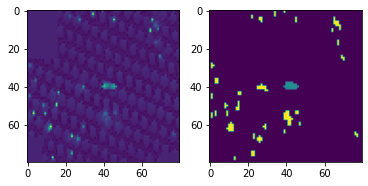

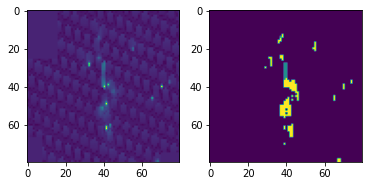

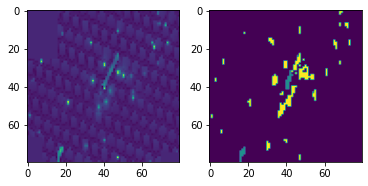

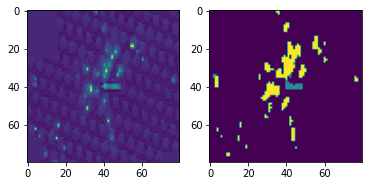

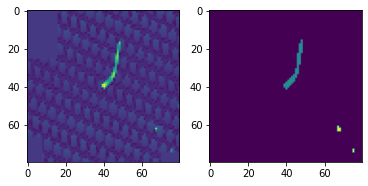

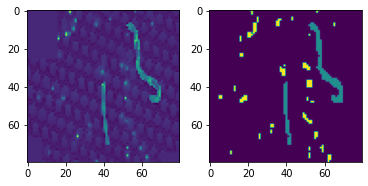

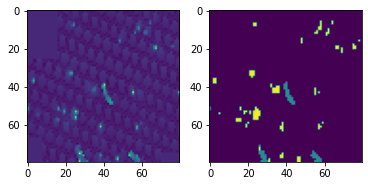

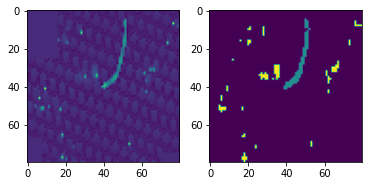

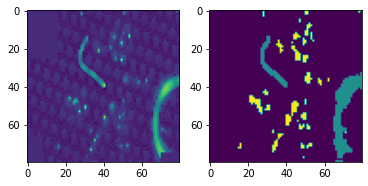

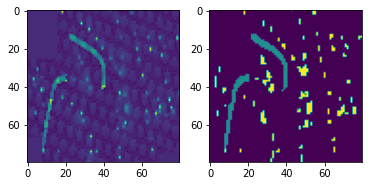

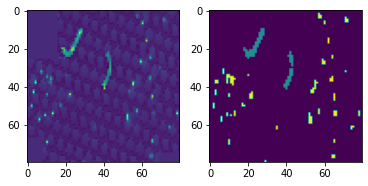

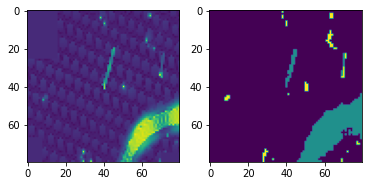

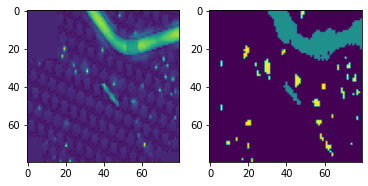

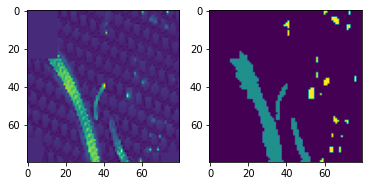

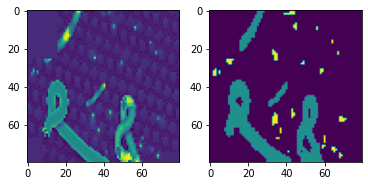

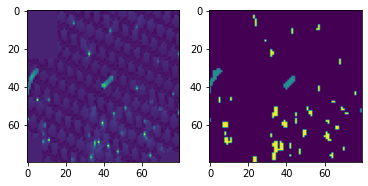

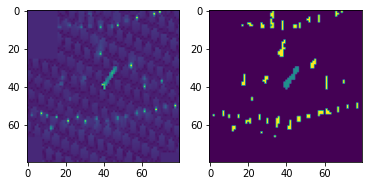

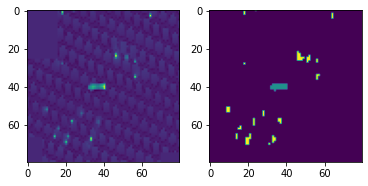

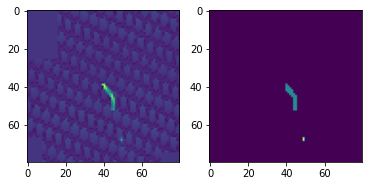

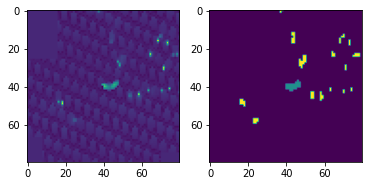

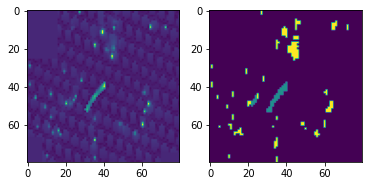

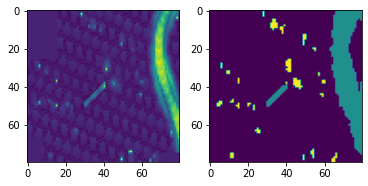

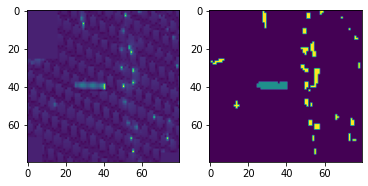

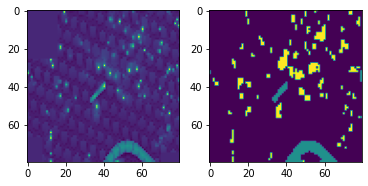

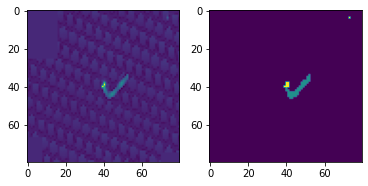

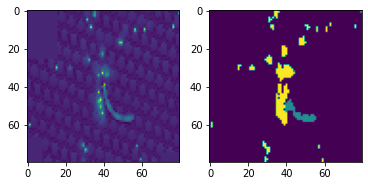

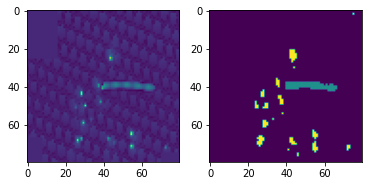

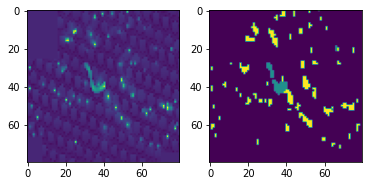

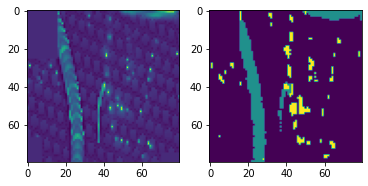

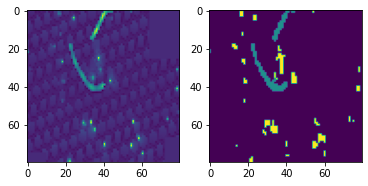

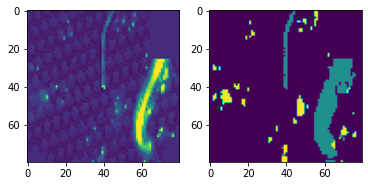

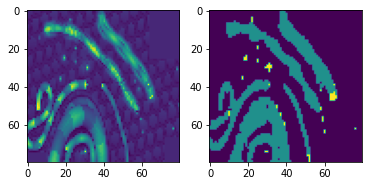

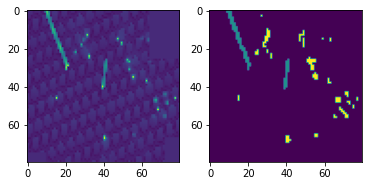

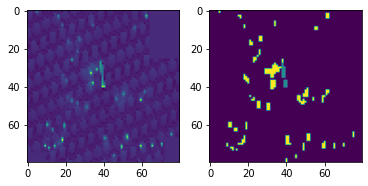

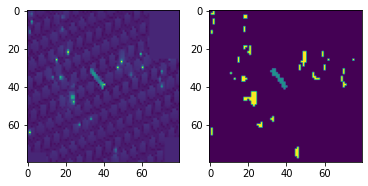

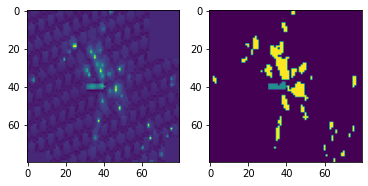

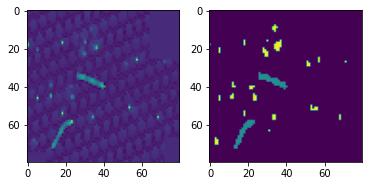

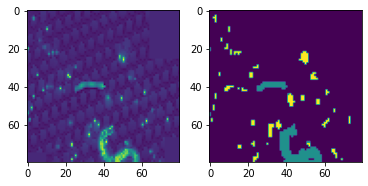

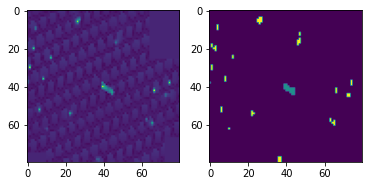

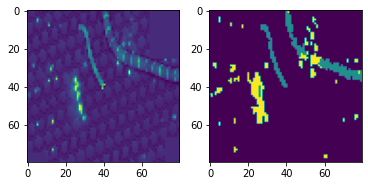

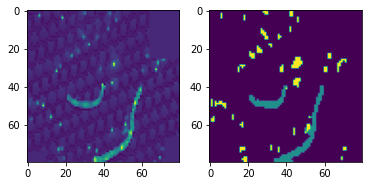

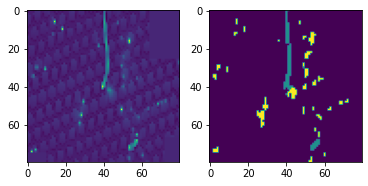

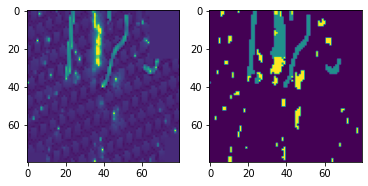

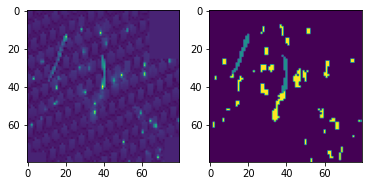

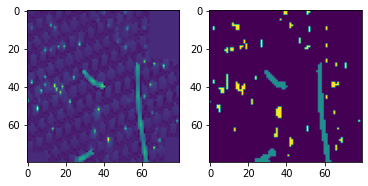

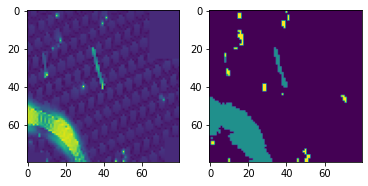

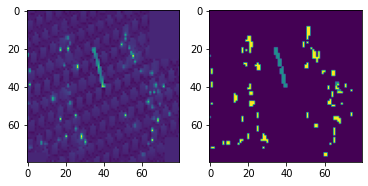

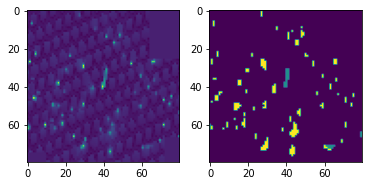

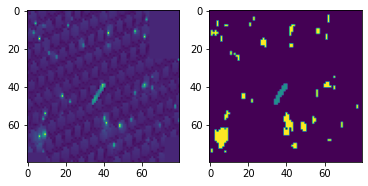

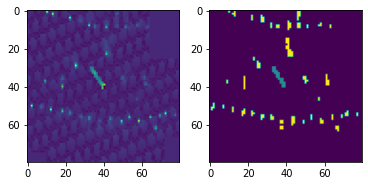

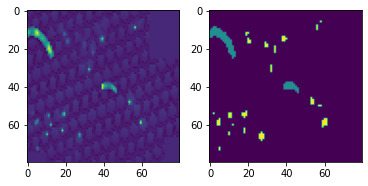

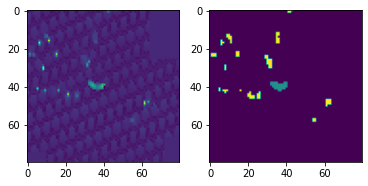

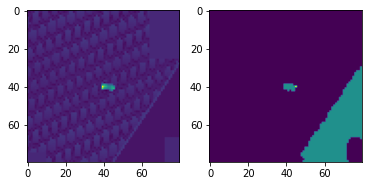

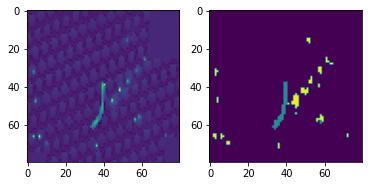

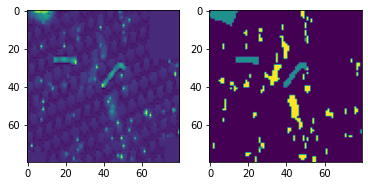

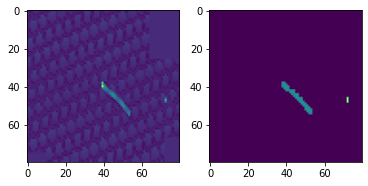

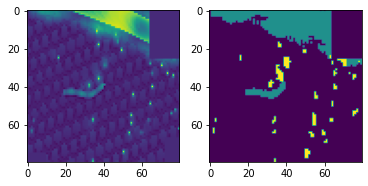

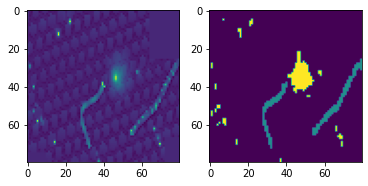

In [45]:
import time

#plot test image and the result
for filename in os.listdir('./final_train_data/same/test'):
    if 'input' in filename:
        temp = torch.load('./final_train_data/same/test/' + filename).unsqueeze(0)
        result = unet(temp.cpu())
        temp = temp.cpu().squeeze(0).squeeze(0)
        
        result = result.squeeze(0)
        conv_result = np.zeros((80,80))
        
        #converting softmax base prediction into deteministic prediction
        for i in range (0,80):
            for j in range (0,80):
                if result[0][i][j] > result [1][i][j] and result[0][i][j] > result [2][i][j]:
                    conv_result[i][j] = 0
                elif result[1][i][j] > result [0][i][j] and result[1][i][j] > result [2][i][j]:
                    conv_result[i][j] = 1
                else:
                    conv_result[i][j] = 2
                    
        f, axarr = plt.subplots(1,2)
        axarr[0].imshow(temp)
        axarr[1].imshow(conv_result)
        plt.show()
